# Example of how to do a mosaic from a continuous emission reconstruction

We do a sky reconstruction for different pointings of our HI test catalogs and then we coadd the pointings. For the reconstruction we assume a gaussian primary beam of around 1 degree FWHM.

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
import astropy.units as u

from astropy.io import fits
from astropy.wcs import WCS
from astropy import coordinates as coords

from karabo.simulation.sky_model import SkyModel
from karabo.simulation.line_emission import freq_channels, karabo_reconstruction
from karabo.imaging.mosaic import mosaic_directories


from karabo.util.plotting_util import get_slices

from MontagePy.main import *
from MontagePy.archive import *


%matplotlib inline

The RASCIL data directory is not available - continuing but any simulations will fail


The observation location should be compatible with the MeerKAT site. Also, the observation time and the coordinate has to be set. We need to pay attention that the sky model passes through the field of view during the observation!

In [2]:
# Specify an observation time -> take whatever you want
t_obs = "2000-03-20 12:06:39"  # 2022-09-01 09:09:00.
t_len = "03:05:00.000"
observing_time = Time(t_obs)

ra_deg = 20.0  # phase_center.ra.deg
dec_deg = -30.0  # phase_center.dec.deg

Parameter definitions.

In [3]:
# Parameters needed for our sky reconstruction
catalog_path = "data/point_sources_OSKAR1_diluted5000.h5"
outer_rad = 5.0  # We define the FOV size with an outer radius, the center of the radius is phase-center
area = 5  # angular size of FOV in degrees
channel_num = 10  # Number of frequency channels to be used
timestep_num = 10  # Number of time steps used

# These are the parameters defining the mosaic we want to make and the pointings
location = "20.0 -30.0"
phase_center = (20.0, -30.0) * u.deg
size = 5.0 * u.deg

# Parameters for the plots
vmax = 0.4
vmax_i = 0.1
vmax_rec = 0.2

We create the sky

The catalog keys are: ['Declination', 'Flux', 'Observed Redshift', 'Right Ascension']
The unit of the flux given here is: J/m²/s = 10^(26)*Jy*Hz
Number of elements in the complete catalog: 223930
Number of elements in diluted catalog in the interesting FOV: 1277


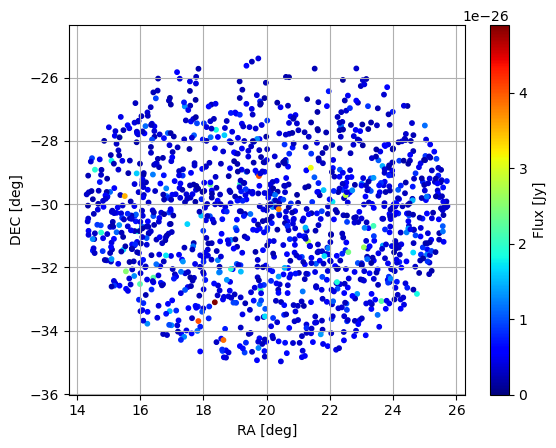

In [4]:
sky_pointing = SkyModel.sky_from_h5_with_redshift_filtered(
    catalog_path, ra_deg, dec_deg, outer_rad
)
sky_pointing.explore_sky(
    phase_center=(ra_deg, dec_deg),
    vmin=0,
    s=10,
    cmap="jet",
    cbar_label="Flux [Jy]",
    cfun=None,
    wcs_enabled=False,
    xlabel="RA [deg]",
    ylabel="DEC [deg]",
)

In [5]:
# Load sky into memory and close connection to h5
sky_pointing.compute()

Frequency/Redshift channels

In [6]:
redshift_channel, freq_channel, freq_bin, freq_mid = freq_channels(
    sky_pointing.sources[:, 13], channel_num
)
print(freq_channel[-1])

Smallest redshift: <xarray.DataArray 'array-74733df9029571afa9be25bd92ba1775' ()>
array(0.769394)
Largest redshift: <xarray.DataArray 'array-74733df9029571afa9be25bd92ba1775' ()>
array(1.030887)
The frequency channel starts at: 806820376.5432308 Hz
The bin size of the freq channel is: 11750085.933512092 Hz
702935777.9794413


In [7]:
FWHM_ref = (
    1 * u.deg
)  # reference FWHM of the simulated gaussian primary beam (FWHM at 1.5GHz)

FWHM_real = np.sqrt(89.5 * 86.2) / 60.0 * (1e3 / (freq_mid / 10**6)) * u.deg
print("The FWHM of the Gaussian primary beam at the mid frequency is: ", FWHM_real)
fac = 0.87  # This is the ideal position if the primary beam is gaussian
offset = (
    FWHM_real * fac
)  # Radial distance between central pointing and the other pointings

img_size = 1024  # Pixel size of the pointing
size_pntg = 1.2 * FWHM_real  # Size of the pointing in degrees

# Position of the pointings
center1 = coords.SkyCoord(ra=phase_center[0], dec=phase_center[1], frame="icrs")
center2 = coords.SkyCoord(
    ra=phase_center[0] + offset, dec=phase_center[1], frame="icrs"
)
pointings = [
    center1,
] + [center2]

print(pointings)

print(pointings[1].ra.deg)

The FWHM of the Gaussian primary beam at the mid frequency is:  1.9392646776743094 deg
[<SkyCoord (ICRS): (ra, dec) in deg
    (20., -30.)>, <SkyCoord (ICRS): (ra, dec) in deg
    (21.68716027, -30.)>]
21.687160269576648


In [8]:
workdir = "results/Mosaic_test_2"
mosaic_directories(workdir)

We do a sky reconstruction for every redshift bin for every pointing and save it in the corresponding folders.

Reconstruction of pointing 0...
Saved visibility to results/Mosaic_test_2/unused_output/pointing0.vis
Reconstruction of pointing 1...
Saved visibility to results/Mosaic_test_2/unused_output/pointing1.vis


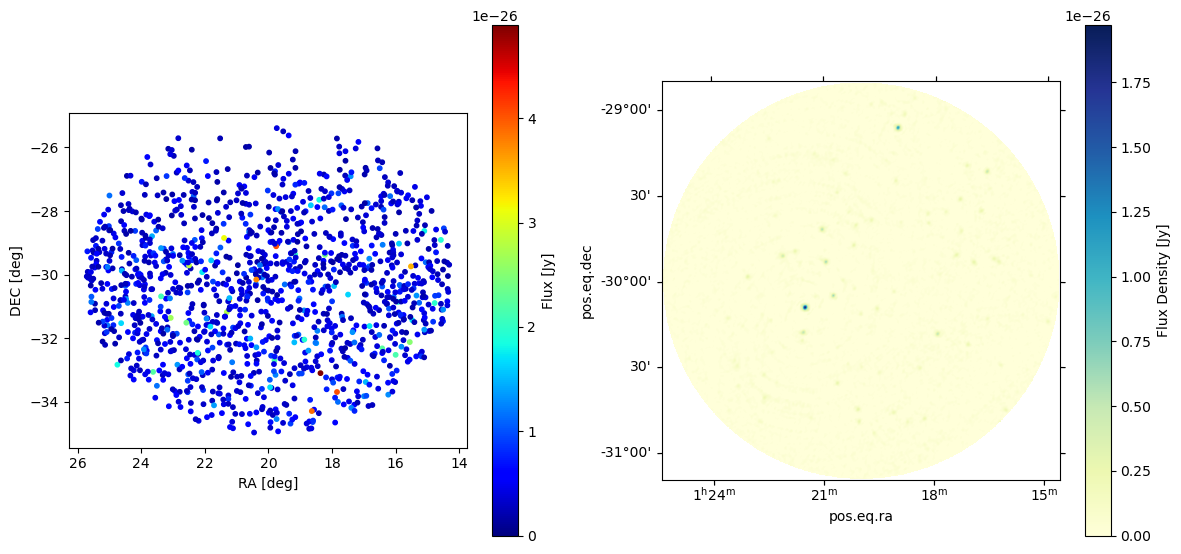

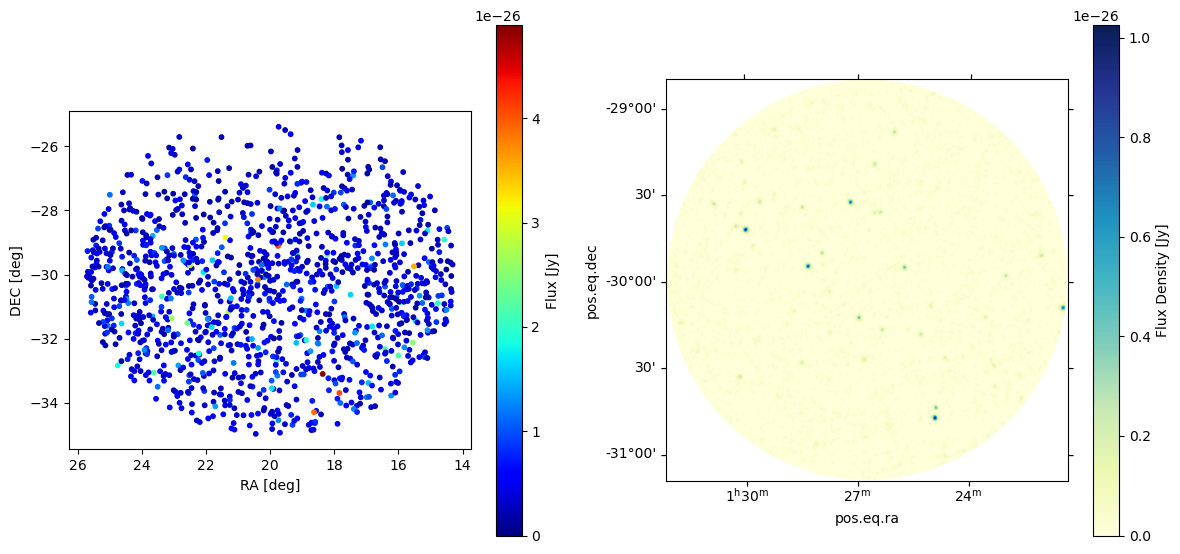

In [9]:
outfile = workdir + "/unused_output/pointing"

for k in range(len(pointings)):
    print("Reconstruction of pointing " + str(k) + "...")

    image, header = karabo_reconstruction(
        outfile=outfile + str(k),
        mosaic_pntg_file=workdir + "/raw/pointing" + str(k),
        sky=sky_pointing,
        ra_deg=pointings[k].ra.deg,
        dec_deg=pointings[k].dec.deg,
        img_size=img_size,
        start_freq=freq_mid,
        freq_bin=freq_channel[0] - freq_channel[-1],
        beam_type="Gaussian beam",
        cut=size_pntg.value,
        channel_num=1,
        pdf_plot=True,
        circle=True,
    )

Now let us start with the actual mosaicing, for every redshfit bin. We first need to create the FITS header for the mosaic, which is the same in every redshift channel. Then we additionally create a file for every channel which contains the metadata of the pointings in this channel. With these two files we create the reprojections which we then use to coadd the pointings.

In [ ]:
rtn = mHdr(
    locstr=location,
    width=size.value,
    height=size.value,
    outfile="region.hdr",
    resolution=5,
    csys="Equatorial",
)
print("mHdr:             " + str(rtn), flush=True)

# Replace the projection -> to SIN (orthographic)
with open("region.hdr", "r", encoding="utf-8") as file:
    data = file.readlines()

print(data)
data[5] = "CTYPE1  = 'RA---SIN'\n"
data[6] = "CTYPE2  = 'DEC--SIN'\n"

with open("region.hdr", "w", encoding="utf-8") as file:
    file.writelines(data)


# Scan the images for their coverage metadata.
rtn = mImgtbl("raw", "rimages.tbl")
print("mImgtbl (raw):    " + str(rtn), flush=True)

Calculate the differences of the overlaping regions.

In [ ]:
# Reproject the original images to the  frame of the output FITS header we created
rtn = mProjExec("raw", "rimages.tbl", "region.hdr", projdir="projected")
print("mProjExec:           " + str(rtn), flush=True)

In [ ]:
mImgtbl("projected", "pimages.tbl")
print("mImgtbl (projected): " + str(rtn), flush=True)

Coadding:

In [ ]:
rtn = mAdd("projected", "pimages.tbl", "region.hdr", "mosaic.fits")
print("mAdd:                " + str(rtn), flush=True)

Primary Beam Correction

In [ ]:
# prim_beam_mosaic, prim_header_mosaic = fits.getdata(
#     "Primary_Beam/mosaic.fits", ext=0, header=True
# )
# dirty_image = dirty_image / prim_beam_mosaic

In [ ]:
# wcs = WCS(header)
# print(wcs)
#
# slices = get_slices(wcs)
#
# plt.figure(figsize=(20, 10))
#
# ax1 = plt.subplot(1, 2, 1)
# scatter = ax1.scatter(
#     sky_pointing[:, 0],
#     sky_pointing[:, 1],
#     c=sky_pointing[:, 2],
#     vmin=0,
#     vmax=vmax,
#     s=10,
#     cmap="jet",
# )
# ax1.set_aspect("equal")
# plt.colorbar(scatter, ax=ax1, label="Flux [Jy]")
# ax1.set_xlim((ra_deg - size.value / 2, ra_deg + size.value / 2))
# ax1.set_ylim((dec_deg - size.value / 2, dec_deg + size.value / 2))
# ax1.set_xlabel("RA [deg]")
# ax1.set_ylabel("DEC [deg]")
# ax1.invert_xaxis()
#
# ax2 = plt.subplot(122, projection=wcs, slices=slices)
# recon_img = ax2.imshow(dirty_image, cmap="YlGnBu", origin="lower", vmin=0, vmax=0.1)
# plt.colorbar(recon_img, ax=ax2, label="Flux Density [Jy]")
#
# plt.title("Reconstructed image")
# plt.tight_layout()
# plt.savefig("Mosaic.pdf")
plt.show()

In [ ]:
fits.writeto("mosaic_total.fits", dirty_image, header, overwrite=True)

# Plot Scatterplot onto Reconstruction

In [ ]:
dirty_image, header = fits.getdata("mosaic.fits", ext=0, header=True)

wcs = WCS(header)
print(wcs)

slices = get_slices(wcs)

plt.figure(figsize=(20, 10))

ax1 = plt.subplot(1, 2, 1)
scatter = ax1.scatter(
    sky_pointing[:, 0],
    sky_pointing[:, 1],
    c=sky_pointing[:, 2],
    vmin=0,
    s=10,
    cmap="jet",
)
ax1.set_aspect("equal")
plt.colorbar(scatter, ax=ax1, label="Flux [Jy]")
ax1.set_xlim((ra_deg - size.value / 2, ra_deg + size.value / 2))
ax1.set_ylim((dec_deg - size.value / 2, dec_deg + size.value / 2))
ax1.set_xlabel("RA [deg]")
ax1.set_ylabel("DEC [deg]")
ax1.invert_xaxis()

ax2 = plt.subplot(122, projection=wcs, slices=slices)
recon_img = ax2.imshow(dirty_image, cmap="YlGnBu", origin="lower", vmin=0)
plt.colorbar(recon_img, ax=ax2, label="Flux Density [Jy]")

plt.title("Reconstructed image")
plt.tight_layout()
plt.savefig("Mosaic.pdf")
plt.show()